In [1]:
import sys
import os



sys.path.insert(0, './models')
os.chdir('../low-unrolled')

os.environ["CUDA_VISIBLE_DEVICES"]= '0'




In [2]:
import keras
import tensorflow as tf
import numpy as np
import scipy.io as sio
import h5py

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
from models.utils import *
from models.Alpha8L import *
from matplotlib import pyplot as plt

data_dir = '../data/kaist_dataset/train_dataset/'
val_dir = '../data/kaist_dataset/test_dataset/'

B = 27
images_names = [ "Image_" +str(i+1) + ".mat" for i in range(B)]
val_names =  [ "Image_" +str(i+1) + ".mat" for i in range(27,30)]

print(images_names)
print(val_names)
weights = './weights/8LPriorBest'

['Image_1.mat', 'Image_2.mat', 'Image_3.mat', 'Image_4.mat', 'Image_5.mat', 'Image_6.mat', 'Image_7.mat', 'Image_8.mat', 'Image_9.mat', 'Image_10.mat', 'Image_11.mat', 'Image_12.mat', 'Image_13.mat', 'Image_14.mat', 'Image_15.mat', 'Image_16.mat', 'Image_17.mat', 'Image_18.mat', 'Image_19.mat', 'Image_20.mat', 'Image_21.mat', 'Image_22.mat', 'Image_23.mat', 'Image_24.mat', 'Image_25.mat', 'Image_26.mat', 'Image_27.mat']
['Image_28.mat', 'Image_29.mat', 'Image_30.mat']


In [4]:
dataset_size = (B,512,512,31)
val_size = (3,512,512,31)
RGB = [22, 14 , 5]
Y = np.zeros(dataset_size)
Y_val = np.zeros(val_size)

In [5]:
i = 0

for name in images_names:
  with h5py.File(data_dir+name, 'r') as f:
      h = f.get('Data_24b')[:]
      h = np.transpose( h , (2,1,0))
      Y[i] = h 
      i = i +1
i = 0
for name in val_names:
  with h5py.File(val_dir+name, 'r') as f:
      h = f.get('Data_24b')[:]
      h = np.transpose( h , (2,1,0))
      Y_val[i] = h 
      i = i +1


Y = np.float32(Y)  
Y_val = np.float32(Y_val)  
B, M , N , C = Y.shape   
input_size = (M,N,C)
print(Y.shape)
print(Y_val.shape)

(27, 512, 512, 31)
(3, 512, 512, 31)


Transmitancia:  0.30031999538745385


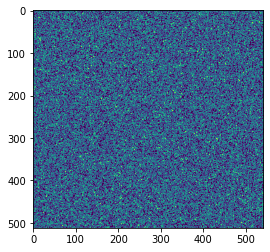

In [6]:
ca_shape = (1 , M , N + C - 1, 1)
coded_aperture = np.random.random(ca_shape)

coded_aperture = np.asanyarray( (coded_aperture<0.3)*1, dtype=np.float32)
ca_total= np.prod(ca_shape)

T = np.linalg.norm( coded_aperture.flatten(),1)  / ca_total

print('Transmitancia: ', T)

plt.imshow(coded_aperture[0,:,:,0])

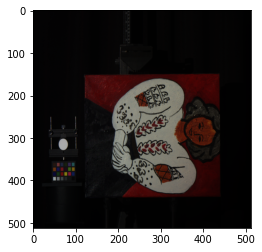

In [7]:
plt.imshow(Y_val[0,:,:,:][:,:,RGB])

In [8]:
I = dd_cassi(Y,coded_aperture)
I_val = dd_cassi(Y_val,coded_aperture)
print(I.shape)
print(I_val.shape)

(27, 512, 512, 1)
(3, 512, 512, 1)


In [9]:
print(coded_aperture.shape[1:])

(512, 542, 1)


In [10]:
initial_learning_rate = 1e-7
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100*27,
    decay_rate=0.9,
    staircase=True)

optimizad = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

main_model = HSI_net(coded_aperture, input_size=input_size,  pretrained_weights=weights )
autoencoder = main_model.autoencoder
encoder = main_model.encoder 
decoder = main_model.decoder

autoencoder.compile(optimizad , 'mse')
decoder.compile(optimizad ,'mse')
encoder.compile(optimizad ,'mse')

In [11]:
import tensorflow as tf
from tensorflow.keras import backend as K

def my_rmse(y_true, y_pred):   

    y_pred = tf.unstack(y_pred, num=None, axis=-1)
    loss = tf.reduce_mean( [ tf.keras.losses.MSE(y_true, i) for i in y_pred])
    return loss


def psnr(y_true,y_pred):
  # return tf.image.psnr(y_true, y_pred, max_val=K.max(y_true))
  return tf.image.psnr(y_true, tf.unstack(y_pred , axis=-1)[-1], max_val=K.max(y_true))



recons = main_model.recons_net
recons.compile(optimizad, metrics=[psnr],loss = my_rmse)

In [12]:
recons.summary()

Model: "recons-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
Xint (Lambda)                   (None, 512, 512, 31) 0           Input[0][0]                      
__________________________________________________________________________________________________
lEnconder (Lambda)              (None, 512, 512, 8)  0           Xint[0][0]                       
__________________________________________________________________________________________________
init_zeros (Lambda)             multiple             0           lEnconder[0][0]                  
                                                                 Xint[0][0]              

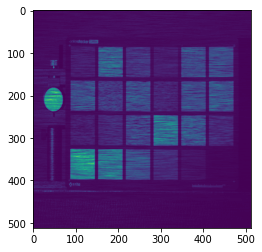

In [13]:
plt.imshow(I[0,:,:,0])

In [14]:
!ls ./weights/

8LPriorBest.data-00000-of-00001  Recons8l_10stages_1000epochs.h5
8LPriorBest.index		 Recons8l_10stages_3000epochs_best.h5
8LPrior.h5			 Recons8l_10stages_400epochs.h5
Alpha16L_Kaist.h5		 Recons8l_10stages.h5
Alpha8L_Kaist.h5		 Recons8l_9stages_100epochs.h5
Autoencoder_Kaist.h5		 weights_Kaist.rar


In [15]:
from keras.callbacks import ModelCheckpoint

check_path = './weights/Recons8l_10stages_3000epochs_best.h5'
checkpoint = ModelCheckpoint(check_path, monitor='val_loss', verbose=1,
    save_best_only=True, save_weights_only=True ,mode='auto', save_freq='epoch')


recons.load_weights('./weights/Recons8l_10stages_1000epochs.h5')

In [ ]:
history = recons.fit( x=I , y=Y, epochs=2000, batch_size=1, validation_data=(I_val, Y_val), callbacks=[checkpoint], verbose=2)

Epoch 1/2000
27/27 - 214s - loss: 0.0019 - psnr: 29.7876 - val_loss: 0.0018 - val_psnr: 29.6791

Epoch 00001: val_loss improved from inf to 0.00180, saving model to ./weights/Recons8l_10stages_3000epochs_best.h5
Epoch 2/2000
27/27 - 16s - loss: 0.0019 - psnr: 29.7988 - val_loss: 0.0018 - val_psnr: 29.6846

Epoch 00002: val_loss improved from 0.00180 to 0.00180, saving model to ./weights/Recons8l_10stages_3000epochs_best.h5
Epoch 3/2000
27/27 - 17s - loss: 0.0019 - psnr: 29.8049 - val_loss: 0.0018 - val_psnr: 29.6916

Epoch 00003: val_loss improved from 0.00180 to 0.00180, saving model to ./weights/Recons8l_10stages_3000epochs_best.h5
Epoch 4/2000
27/27 - 17s - loss: 0.0019 - psnr: 29.8102 - val_loss: 0.0018 - val_psnr: 29.6975

Epoch 00004: val_loss improved from 0.00180 to 0.00180, saving model to ./weights/Recons8l_10stages_3000epochs_best.h5
Epoch 5/2000
27/27 - 17s - loss: 0.0019 - psnr: 29.8144 - val_loss: 0.0018 - val_psnr: 29.7029

Epoch 00005: val_loss improved from 0.00180 to 

In [ ]:
recons.save_weights('./weights/Recons8l_10stages_3000epochs.h5')

In [ ]:
plt.plot(history.history["loss"])